This notebook is to find the statistics of the EUV wave in SUVI and LASCO C2/C3

In [97]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

data_dir = '/home/mnedal/data'

In [98]:
# suvi, lasco_C2, lasco_C3

In [99]:
suvi_filenames = sorted(glob.glob(f'{data_dir}/jplots/suvi/clicking/*.csv'))
c2_filenames   = sorted(glob.glob(f'{data_dir}/jplots/lasco_C2/clicking/*.csv'))
c3_filenames   = sorted(glob.glob(f'{data_dir}/jplots/lasco_C3/clicking/*.csv'))

print(len(suvi_filenames), len(c2_filenames), len(c3_filenames))

13 16 7


In [100]:
slits = myfuncs.generate_centered_list(160, 2, 6)
print(slits, '--> Length:', len(slits))

[148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172] --> Length: 13


In [101]:
# Filter filenames based on the slit number
suvi_filenames = [
    filename for filename in suvi_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

c2_filenames = [
    filename for filename in c2_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

c3_filenames = [
    filename for filename in c3_filenames 
    if any(filename.endswith(f'slit_{n}.csv') for n in slits)
]

print(len(suvi_filenames), len(c2_filenames), len(c3_filenames))

13 13 7


In [102]:
all_speeds_suvi = []
all_accels_suvi = []
for file in suvi_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_suvi.append(df['speed_km_s'].values)
    all_accels_suvi.append(df['accel_m_s2'].values)

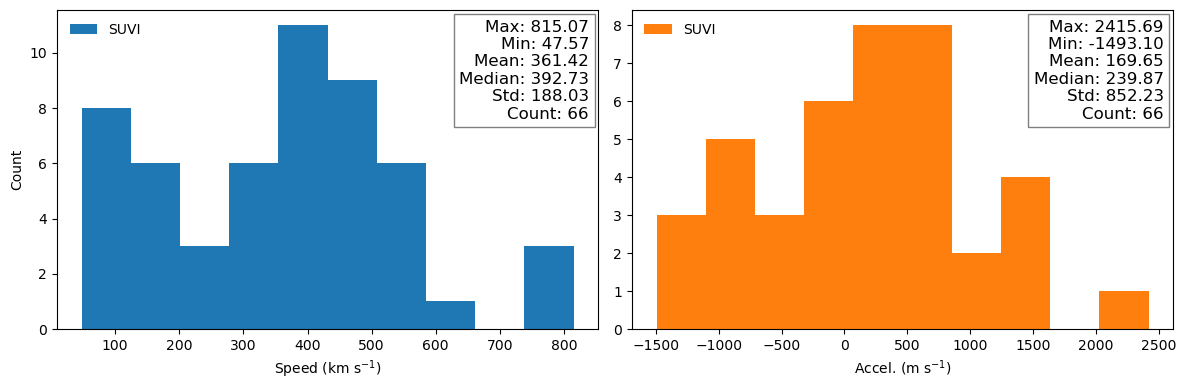

In [117]:
# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_suvi)
combined_array_a = np.concatenate(all_accels_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='SUVI',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.983, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='SUVI')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.983, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_suvi.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [84]:
all_speeds_c2 = []
all_accels_c2 = []
for file in c2_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_c2.append(df['speed_km_s'].values)
    all_accels_c2.append(df['accel_m_s2'].values)

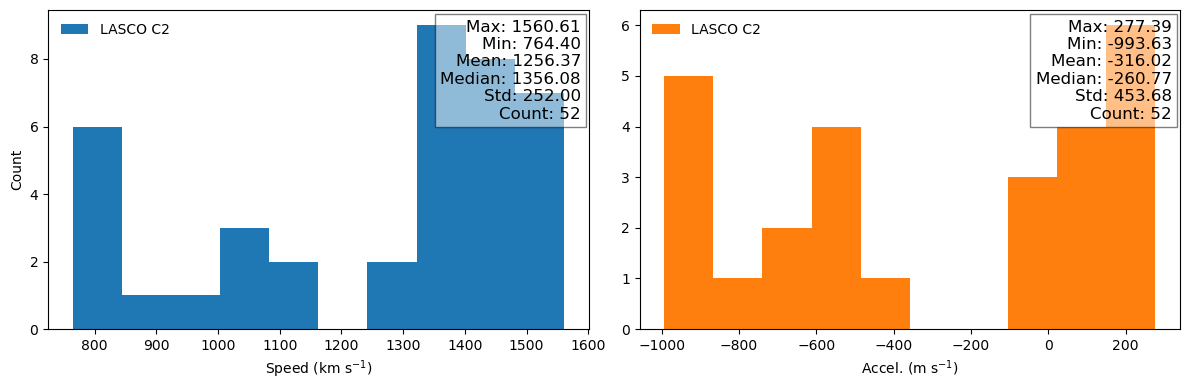

In [120]:
# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_c2)
combined_array_a = np.concatenate(all_accels_c2)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

# Plot a histogram of the combined data
fig = plt.figure(figsize=[12,4])

ax = fig.add_subplot(121)
ax.hist(combined_array_v, bins=10, color='tab:blue', label='LASCO C2',
         # edgecolor='black'
        )
ax.set_xlabel(r'Speed (km s$^{-1}$)')
ax.set_ylabel('Count')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_v = f'Max: {max_v:.2f}\nMin: {min_v:.2f}\nMean: {mean_v:.2f}\nMedian: {median_v:.2f}\nStd: {std_v:.2f}\nCount: {count_v}'
ax.text(0.986, 0.97, stats_text_v, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

ax = fig.add_subplot(122)
ax.hist(combined_array_a, bins=10, color='tab:orange', label='LASCO C2')
ax.set_xlabel(r'Accel. (m s$^{-1}$)')
ax.legend(loc='upper left', frameon=False)
# Add statistics to the top-right corner of the plot
stats_text_a = f'Max: {max_a:.2f}\nMin: {min_a:.2f}\nMean: {mean_a:.2f}\nMedian: {median_a:.2f}\nStd: {std_a:.2f}\nCount: {count_a}'
ax.text(0.985, 0.97, stats_text_a, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig(f'{data_dir}/euv_stats_c2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [96]:
suvi_filenames

['/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_148.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_150.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_152.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_154.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_156.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_158.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_160.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_162.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_164.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_166.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_168.csv',
 '/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_170.csv',
 '/home/mnedal/data/jplots/suvi/clicking

In [94]:
c3_filenames

['/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_154.csv',
 '/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_156.csv',
 '/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_158.csv',
 '/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_160.csv',
 '/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_162.csv',
 '/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_164.csv',
 '/home/mnedal/data/jplots/lasco_C3/clicking/jmap_LASCO_C3_20240514_slit_166.csv']